# **Exploratory Data Analysis**

In this notebook, we'll preprocess our available data, consisting of a [Kaggle Dataset](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) and webscraped data. The Kaggle Dataset will be used for model training, while the webscraped data will serve as an out-of-sample dataset to test how well our models generalize to new, unforeseen data.

# Kaggle Dataset

Let's import the needed libraries and load the data, which is stored in a `JSON` file under the `data` folder.

In [1]:
# Python base libraries
import os

# Data science libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from textblob import Word
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import plotly.express as px

# Custom libraries
from src.data_exploration.data_preprocessing import *
from src.data_exploration.eda import *
from src.utils.misc_utils import *

In [2]:
# Load data
filepath = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.json")
data_json = list(load_json(filepath))

# Show first 5 rows
data_json[:5]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'},
 {'is_sarcastic': 0,
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'},
 {'is_sarcastic': 1,
  'headline': 'inclement weather prevents liar from getting to work',
  'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'},
 {'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-

We can appreciate the dataset contains a list of dictionaries, each of which has 3 keys:

- `is_sarcastic`: 1 if the article is sarcastic, 0 otherwise.
- `headline`: the headline of the news article.
- `article_link`: link of the news article from which the sentence was extracted.

In order to be able to manipulate the data easier, we will convert the dataset into a `pandas` dataframe.

In [3]:
# Convert the dictionary list into a pandas DataFrame
data = (pd.DataFrame(data_json)
    # Drop the article link column
    .drop(columns=['article_link'])
    # Rename the is_sarcastic column
    .rename(columns={'is_sarcastic': 'label'})
)

# Show first rows
data.head()

,label,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


## Check for duplicates

Let's see if there are any duplicates in the DataFrame, so we can remove them:

In [4]:
# Number of duplicate rows
data.duplicated().sum()

116

We can see there are 116 rows duplicated, so we will remove them.

In [5]:
data.drop_duplicates(inplace=True)
data.shape

(28503, 2)

## Check datatypes and missing values

Let's now see the datatypes, as well as if there is any missing value.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     28503 non-null  int64 
 1   headline  28503 non-null  object
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


It can be appreciated that:

- The headlines are stored as `object` type, which is the correct datatype for columns of String type.
- The labels are stored as `int64` type, which also correct.

With respect to the missing values, there are none in the dataset.

## Analyze class imbalance

One main aspect when dealing with a classification problem is class imbalance. Therefore, let's see how many rows for each class our dataset has:

In [7]:
check_class_imbalance(data, 'label')

,label,Freq,Rel_Freq
0,0,14951,0.524541
1,1,13552,0.475459


When training a model, imbalanced classes can lead to bias towards the larger class. For example, a model with 90% accuracy on a dataset with 90% negative class is no better than a model that predicts negative for all samples. To combat class imbalance, techniques like **upsampling** (adding minority class samples) or **downsampling** (reducing majority class samples) can be used. In some cases, a combination of both may be necessary.

It can be observed that there is a class imbalance in our dataset, with the negative class (not sarcastic articles) having approximately 1400 more labels than the positive class (sarcastic articles). However, it's important to note that the actual difference between both classes is less than 5%, which is a relatively small difference. Therefore, we have decided not to take any measures to correct this class imbalance as it is not significant enough to impact the performance of our model.

## Text preprocessing

In NLP tasks, text preprocessing is necessary to clean the raw text data and prepare it for further analysis. This typically involves a series of steps, including:

- Converting all text to lower case to avoid treating the same word with different capitalizations as separate tokens.
- Expanding contractions (e.g. "can't" to "can not") to standardize text.
- Deleting punctuation marks, numbers, and stopwords is a common text preprocessing step. However, removing stopwords can be problematic as some (e.g. "not" or "but") carry sentiment and contribute to sentence meaning. In the case of our task, as sarcasm determination in headlines is based on patterns and themes conveyed by the overall meaning, it's safe to drop these words.
- Lemmatizing words (reducing them to their base form) to avoid treating different forms of the same word as separate tokens.
- Removing words with very few occurrences to reduce noise in the data.
- Dropping headlines that are either too short or too long, as they may not contain enough information or be too verbose.

By performing these preprocessing steps, we can transform the raw text data into a clean and structured format that is more suitable for analysis and modeling. We'll start by taking a look at the dataset before applying any preprocessing.

In [8]:
data["headline"].values[:10]

array(['thirtysomething scientists unveil doomsday clock of hair loss',
       'dem rep. totally nails why congress is falling short on gender, racial equality',
       'eat your veggies: 9 deliciously different recipes',
       'inclement weather prevents liar from getting to work',
       "mother comes pretty close to using word 'streaming' correctly",
       'my white inheritance',
       '5 ways to file your taxes with less stress',
       "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
       'shadow government getting too large to meet in marriott conference room b',
       'lots of parents know this scenario'], dtype=object)

Load the contractions dataset

In [9]:
contractions = pd.read_csv("data/Contractions.csv", sep=";")

Initialize the stopwords and lemmatizer

In [10]:
# Download stopwords and wordnet
nltk.download("stopwords")
nltk.download("wordnet")

# Load stopwords
stop_words = stopwords.words("english")
# Create lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Apply the initial preprocessing function. After applying the initial preprocessing steps, let's see how the dataset looks like, so we can compare to how it was initially.

In [11]:
# Preprocess text
data["headline"] = data["headline"].apply(lambda x: preprocess_text(x, contractions, stop_words, lemmatizer))
data["headline"].values[:10]

array(['thirtysomething scientist unveil doomsday clock hair loss',
       'dem rep totally nail congress falling short gender racial equality',
       'eat veggie deliciously different recipe',
       'inclement weather prevents liar getting work',
       'mother come pretty close using word streaming correctly',
       'white inheritance', 'way file tax le stress',
       'richard bransons globalwarming donation nearly much cost failed balloon trip',
       'shadow government getting large meet marriott conference room b',
       'lot parent know scenario'], dtype=object)

### Frequency Distribution

In [12]:
# Get the number of occurrences of every word in the dataset
words_count_data = get_word_counts(data, "headline")
words_count_data

,word,frequency
0,trump,1794
1,new,1674
2,man,1497
3,woman,945
4,say,698
...,...,...
25052,registering,1
25053,thirdround,1
25054,cobblestone,1
25055,devastation,1


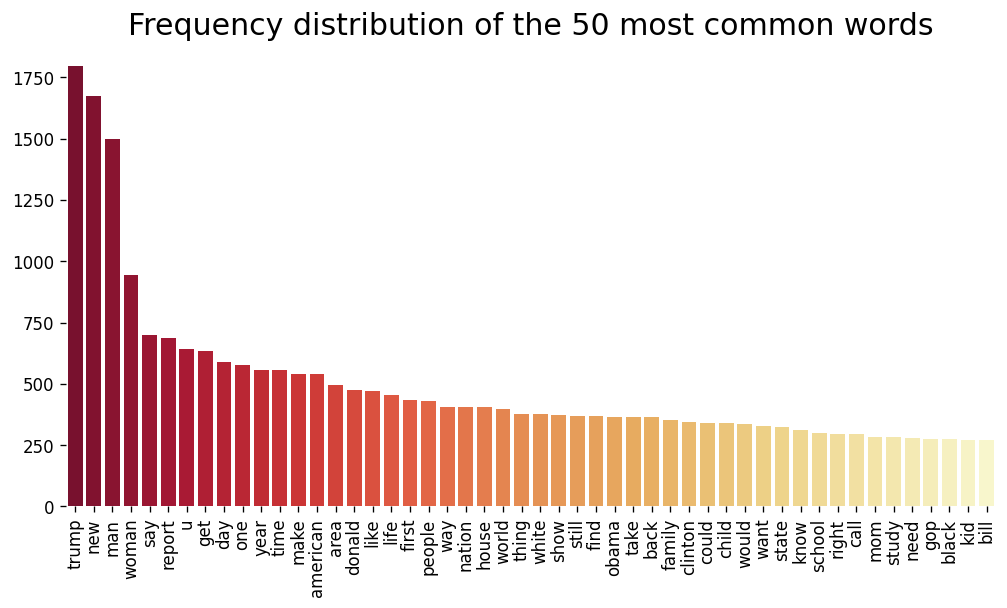

In [13]:
# Plot the frequency distribution of the 50 most common words in the dataset
plot_top_n_words_frequency(words_count_data, "word", "frequency", 50)

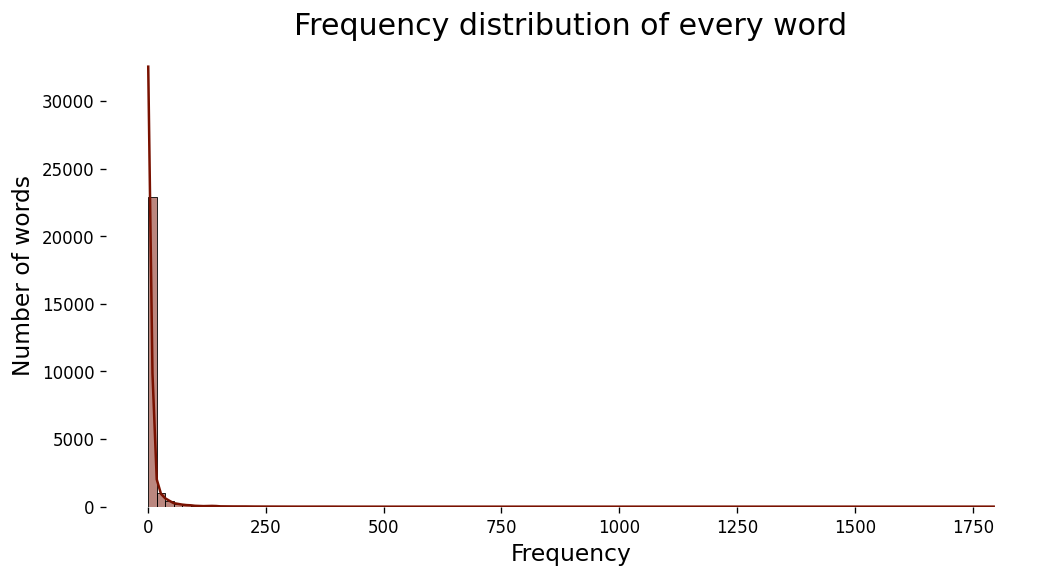

In [14]:
# Plot the frequency distribution of every word in the dataset
plot_word_frequency_distribution(words_count_data, "frequency")

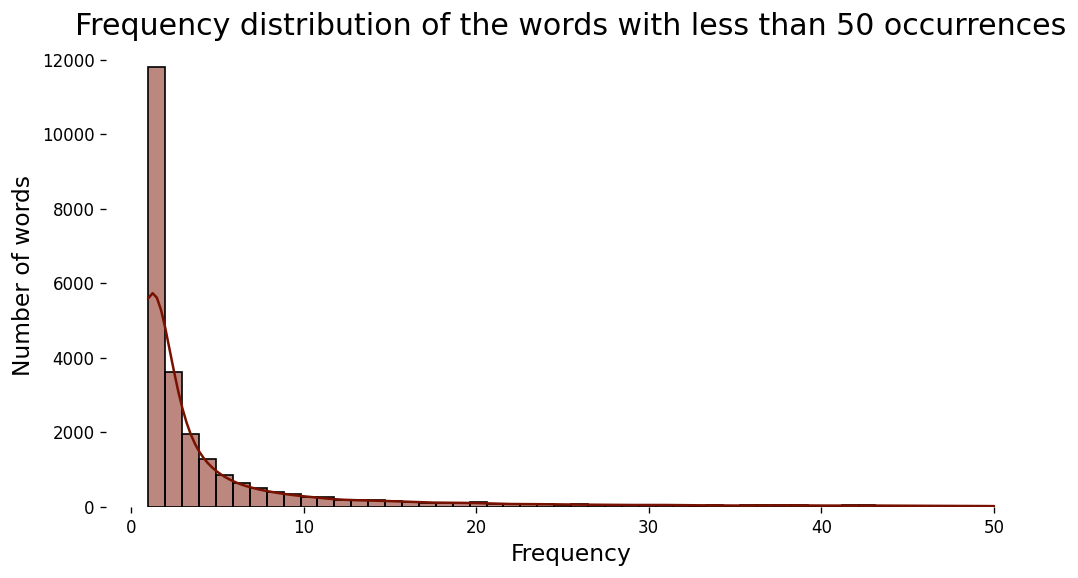

In [15]:
# Plot the frequency distribution of the words with less than 50 occurrences
plot_word_frequency_distribution_n_occurrences(words_count_data, "frequency", 50)

In [16]:
# Print the number of different words in the dataset
print(f"Number of different words in the dataset: {len(words_count_data)}")
# Create a table with the number of words with less than 10, 5, 3 and 2 occurrences
word_counts_aux = pd.DataFrame({"frequency": [10, 5, 3, 2]})
word_counts_aux["number_of_words"] = (
    word_counts_aux["frequency"]
    .apply(lambda x: len(words_count_data[words_count_data["frequency"] < x]))
)
word_counts_aux

Number of different words in the dataset: 25057


,frequency,number_of_words
0,10,21379
1,5,18655
2,3,15432
3,2,11811


The majority of words in the dataset occur very infrequently: almost half of the words appear only once (47%), and over 60% occur twice or less. This suggests that setting a threshold of 2 or 3 would remove a large number of very rare words, without sacrificing too much information. In our case, we will go for a threshold of 3.

In [17]:
# Create a dictionary with the words and their frequency for faster access
word_freq = dict(zip(words_count_data["word"], words_count_data["frequency"]))

# Apply the filter_words_by_frequency function to the "headline" column
data["headline"] = data["headline"].apply(filter_words_by_frequency, args=(word_freq,))

### Headline length distribution

In [18]:
# Get the length of every headline
data["length"] = data["headline"].apply(lambda x: len(x.split()))
data.head()

,label,headline,length
0,1,scientist unveil doomsday clock hair loss,6
1,0,dem rep totally nail congress falling short ge...,10
2,0,eat different recipe,3
3,1,weather prevents liar getting work,5
4,1,mother come pretty close using word streaming ...,8


In [19]:
plot_headline_length_distribution(data, "length", "label")

Drop the headlines with 2 or less elements

In [20]:
# Get the headlines with length 2 or less
short_headlines = data[data["headline"].apply(lambda x: len(x.split()) <= 2)]["headline"].unique()
print(f'There are {len(short_headlines)} headlines with length 2 or less.')
# Drop them
data = data[~data["headline"].isin(short_headlines)]

There are 1374 headlines with length 2 or less.


Drop headlines with 20 or more

In [21]:
# Get the headlines with length 20 or more
long_headlines = data[data["headline"].apply(lambda x: len(x.split()) >= 15)]["headline"].unique()
# Get its length
print(f'There are {len(long_headlines)} headlines with length 20 or more.')
# Drop the headlines with length 20 or more
data = data[~data["headline"].isin(long_headlines)]

There are 26 headlines with length 20 or more.


Let's save the preprocessed dataset into a `CSV` file, so we can use it in following notebooks. Before doing so, we'll remove the empty rows

In [22]:
# Remove the empty rows and keep only the headlines, labels columns
data = data[data["headline"] != ""]
data = data[["headline", "label"]]

# Show first rows
data.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


In [23]:
# Print the final headline length
print(f"Number of rows: {data.shape[0]}")

Number of rows: 27005


Finally, let's save the DataFrame into a `CSV` file.

In [24]:
# Save DataFrame as CSV
data.to_csv(
    path_or_buf=os.path.join("./data", "Sarcasm_Headlines_Dataset_v2.csv"),
    sep=";", quoting=csv.QUOTE_ALL, index=False
)

## Word cloud

It might be interesting to see the most frequent words in the dataset. This can help us have a first intuition of which topics are more frequent in the dataset. For doing so, we will plot a word cloud, which is a visualization commonly used in NLP tasks.

Total number of words: 1176396


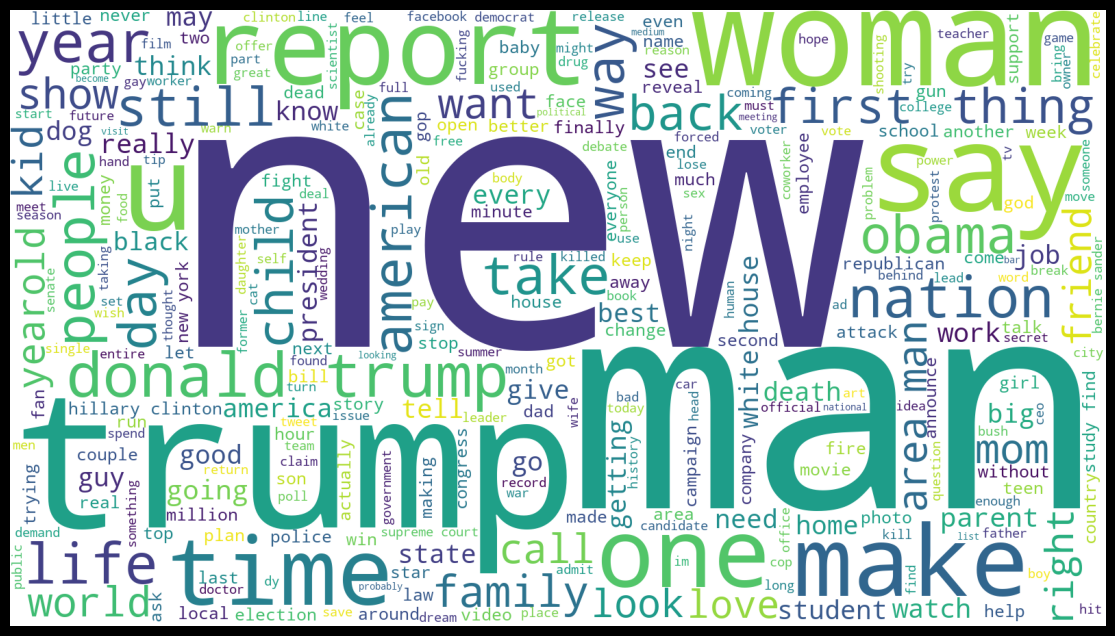

In [25]:
plot_wordcloud(data, "headline")

As it can be seen, some of the most frequent words include:

- `american`: we expected to have news mostly from US, which explains why this word is so frequent. 
- `trump` and `donald trump`: this is not surprising, since US news mention the ex-president quite often. Moreover, we expect that Trump will be specially mentioned in sarcastic articles, since he is a controversial figure.
- `man` and `woman`
- `year`
- `time`
- `life`
- `nation`

Lastly, let's check if the words present in sarcastic and non-sarcastic titles are different

Total number of words for 1: 594946
Total number of words for 0: 581449


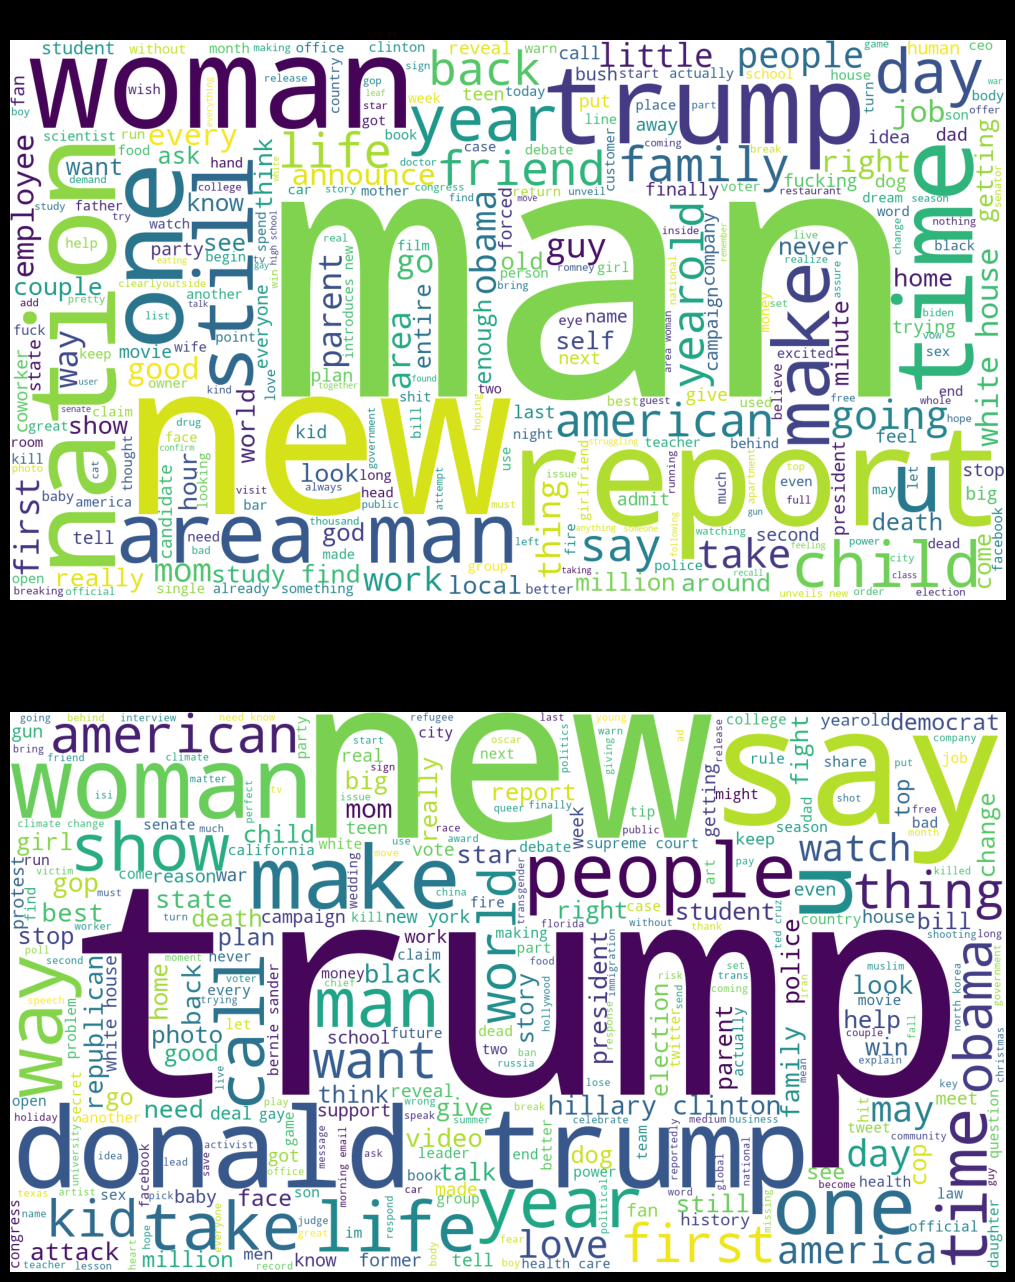

In [26]:
plot_wordcloud_by_label(data, "headline", "label")

Although there are some common words between the two categories, such as `new`, `man`, or `woman`, the primary distinguishing factor between them is Donald Trump. As a highly controversial figure, he has been the subject of many more sarcastic than non-sarcastic articles.

# Out-Of-Sample (OOS) Data